# Summary of Findings


### Introduction
This project creates a model that is designed to predict the severity of major power outages in the US, by the duration of the power outage. Since we are predicting how long the outage will last, this is a regression problem. We chose to use target variables such as the Year, Month, State, Start Time of the day, categorized cause of the outage, GSP contributed by the Utility Industry, the GSP contribution per state as a percentage of the GDP, climate category, and population density data about the state. 

We chose to use the Year, Month, State, and Start time columns because it helps the model to know when and where the power outage is occuring to predict how long it is going to last. For these same reasons, we chose to use the population density and utility GSP columns because it helps the model understand what kind of state the power outage occured in. It helps the model understand the economy of a certain area, which may help because places with higher contribution to the economy, or places that house a lot of people may have quicker recovery times when dealing with power outages. The climate category and categorized cause help the model understand what the different causes might mean in terms of how long the outage will last, and the climate category shows the relative climate during the year of the power outage.

To clean our data, we started with extracting the actual table from the excel file, and then converted the time columns to datetime objects, which will help us later. Then we looked at the OUTAGE.DURATION column's distribution and saw that there were some outages that lasted more than 4 days and some outages that lasted for 0 minutes. We agreed that these data points might have been recording incorrectly and we decided to remove these observations as well as the values of NaN in the column. This removed approximately 316 (~20%) of the observations in our original dataset. While this seemed like a lot initially, this removal of outliers improved our model significantly, therefore we deemed it as necessary. The next part of our cleaning required that we impute some columns that contained missing data. For any columns, we sampled from the data in the column that wasn't null. This way, we were able to preserve the original empirical distribution for categorical data and the original distribution of numerical columns as best we could. Finally, the heatmap that we have displayed was used to see the correlation between the columns of the dataframe with eachother. This is to ensure that we do not have multicollinearity between the columns and make sure our LinearRegression model works well. To evaluate our model, we chose to use the RMSE values to see how inaccurate our predictions were on average to the actual values.
### Baseline Model
We chose to use a LinearRegression model to predict our outage durations. The sklearn package's LinearRegression model has one parameter 'n_jobs' which is a parameter that changes the speed of the computation. To choose the best value for this parameter, we used the GridSearchCV class in the sklearn package. This led us to a best paramter value of 1, which is what we decided to use. Our baseline model, including 6 features, uses the columns: state, categorized cause, climate category, year, outage start time, and the month. The first three are encoded as nominal data using the OneHotEncoder class in the sklearn package. The last three are encoded as ordinal data using the OrdinalEncoder class.

We first split our data into training and test sets to accurately evaluate our model. Then use a ColumnTransformer to encode the nominal and ordinal columns of our base features. We then create a sklearn Pipeline in which we create the process for our model to undergo. Then we fit the pipeline to the training sets, and analyze the model on the test sets using our evaluation metric, RMSE value. Our baseline model, on average, provided an RMSE value of 1181.91 minutes. We also plotted the distributions of the 200 trials we ran our model through.

According to our evaluation metrics, we find that our model is usable but not ideal for predicting the duration of power outages. On average, the difference in predictions is wrong by ~1180 minutes, which is ~20 hours. While a more accurate model could predict within a few hours of the actual end time, the model's ability, on average, to predict the end time within approximately 20 hours is still useful, making it a viable model.
### Final Model
We chose to continue with a LinearRegression for our final model. Our final model includes the rest of the numerical columns that we described in our 'Introduction' portion of this report. The first feature we decided to add is PCA on the nominal categorical columns. This is done to ensure that we don't have multicollinearity in our dataset, because we use a LinearRegresssion this is important. 

We then added the other numerical columns such as UTIL.REALGSP, UTIL.CONTRI, POPDEN_(URBAN, UC, RURAL). The data about the utility industry helps the model understand the current economic status of the utility industry in the area. This can help predict how long the outage will take to be fixed. Additionally, the data about the population densities help identify the amount of people the outage could have affected. This helps us understand how much of a priority this could be in the state, therefore helping us predict how long it takes to get fixed. Out of these extra columns we decided to normalize the UTIL.REALGSP and UTIL.CONTRI because these columns could be correlated to the state column, therefore we wanted to ensure that there would be no related features. However, we decided to leave the population densities as is because the values themselves are important to understanding potential response time. Additionally, we conducted tests on our model with and without normalizing these three columns, and discovered that our model performs better without the normalization of the population density columns.

To find out the best parameter for our PCA transformer, we used GridSearchCV. The PCA transformer has a paramter 'n_components' which is the number of components to keep. We tried 4 different values for this for our GridSearch and discovered that a value of 0.90 was the most ideal, therefore we trained our model with this value.

According to our evaluation metrics, we find that our model performs better than the baseline model, on average, by ~7 minutes. We can confirm this by running our model many times and prediciting the RMSE values of every different split and averaging them, as our code shows. This gives us an estimate of how our model performs on average.
### Fairness Evaluation
To examine the fairness of our model we decided to split our cleaned outages dataframe into the outages that occured within the first 6 months of the year, and those that did not. To do this, we added a column to the dataset to label whether that outage was part of the first half of the year or not. Next, we had to create a new method similar to final_model(), however it needed to contain the paramters for the datasets, in order to train and test on two different groups. 

Each time the fairness_evaluation() method is called, the splitting of training and test sets will be different, therefore our RMSE values will be different each time. Because of this, we need to get a lot of values and average them to obtain a reasonable RMSE value to use in our permutation test.

Our next step was to conduct the permutation test. The test statistic we decided to use is the difference between the RMSE values for the outages that occured in the second-half of the year  and the outages that occured in the first-half of the year (second_half - first_half). We shuffled the column 'first_half' repeatedly, each time obtaining a test statistic from the different groups of the newly shuffled dataset. Then, we plotted the histogram distribution of these repeated trials, and plotted the location of the observed statistic on that histogram, and obtained a p-value for our hypothesis. 

Our null hypothesis was that our model was fair to power outages that occured in the first half of the year and outages that occured in the second half of the year. 

Our alternative hypothesis was that out model favored, produced better results, to either power outages that occured during the first half of the year or power outages that occured during the second half of the year.

After obtaining our pval, we can see that with a significance level of 0.05, we do not have enough information to reject our null hypothesis. That is, there is no reason to believe that our model is unfair, or bias, towards the relative time of year that the power outage occured. 

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
outages = pd.read_excel(os.path.join('data', 'outage.xlsx'))
outages.columns = outages.loc[4].values
outages = outages.loc[6:, :]
outages = outages.drop(columns='variables').set_index('OBS')

outages['OUTAGE.START.TIME'] = pd.to_timedelta(outages['OUTAGE.START.TIME'].astype(str), unit='h')
outages['OUTAGE.START.DATE'] = pd.to_datetime(outages['OUTAGE.START.DATE'])
outages['OUTAGE.START'] = outages['OUTAGE.START.DATE'] + outages['OUTAGE.START.TIME']
outages = outages.drop(columns=['OUTAGE.START.TIME', 'OUTAGE.START.DATE'])

outages = outages[(outages['OUTAGE.DURATION']<=5760) & (outages['OUTAGE.DURATION']>0)]
indexes = outages.index
outages

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.RESTORATION.DATE,OUTAGE.RESTORATION.TIME,...,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-03 00:00:00,20:00:00,...,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2011-07-01 17:00:00
2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:39:00,...,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2014-05-11 18:38:00
3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-28 00:00:00,22:00:00,...,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2010-10-26 20:00:00
4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-20 00:00:00,23:00:00,...,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2012-06-19 04:30:00
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-19 00:00:00,07:00:00,...,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2015-07-18 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526,2011,6,Idaho,ID,WECC,Northwest,-0.3,normal,2011-06-16 00:00:00,06:30:00,...,20.06,2216.8,2004.7,5.6,0.6,0.19,98.8919,1.10807,1.10807,2011-06-15 16:00:00
1529,2016,7,Idaho,ID,WECC,Northwest,-0.3,normal,2016-07-19 00:00:00,19:25:00,...,20.06,2216.8,2004.7,5.6,0.6,0.19,98.8919,1.10807,1.10807,2016-07-19 15:45:00
1530,2011,12,North Dakota,ND,MRO,West North Central,-0.9,cold,2011-12-06 00:00:00,20:00:00,...,19.9,2192.2,1868.2,3.9,0.27,0.1,97.5996,2.40177,2.40177,2011-12-06 08:00:00


### Data Cleaning

,YEAR,MONTH,U.S._STATE,OUTAGE.START,CAUSE.CATEGORY,UTIL.REALGSP,UTIL.CONTRI,CLIMATE.CATEGORY,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL
OBS,,,,,,,,,,,
1,2011,7,Minnesota,17,severe weather,4802.0,1.751391,normal,2279.0,1700.5,18.2
2,2014,5,Minnesota,18,intentional attack,5226.0,1.790002,normal,2279.0,1700.5,18.2
3,2010,10,Minnesota,20,severe weather,4571.0,1.706266,cold,2279.0,1700.5,18.2
4,2012,6,Minnesota,4,severe weather,5364.0,1.932089,normal,2279.0,1700.5,18.2
5,2015,7,Minnesota,2,severe weather,4873.0,1.668704,warm,2279.0,1700.5,18.2
...,...,...,...,...,...,...,...,...,...,...,...
1526,2011,6,Idaho,16,intentional attack,1078.0,1.973961,normal,2216.8,2004.7,5.6
1529,2016,7,Idaho,15,system operability disruption,960.0,1.576070,normal,2216.8,2004.7,5.6
1530,2011,12,North Dakota,8,public appeal,934.0,2.390765,cold,2192.2,1868.2,3.9


OBS
1       3060
2          1
3       3000
4       2550
5       1740
        ... 
1526     870
1529     220
1530     720
1532      59
1533     181
Name: OUTAGE.DURATION, Length: 1218, dtype: object

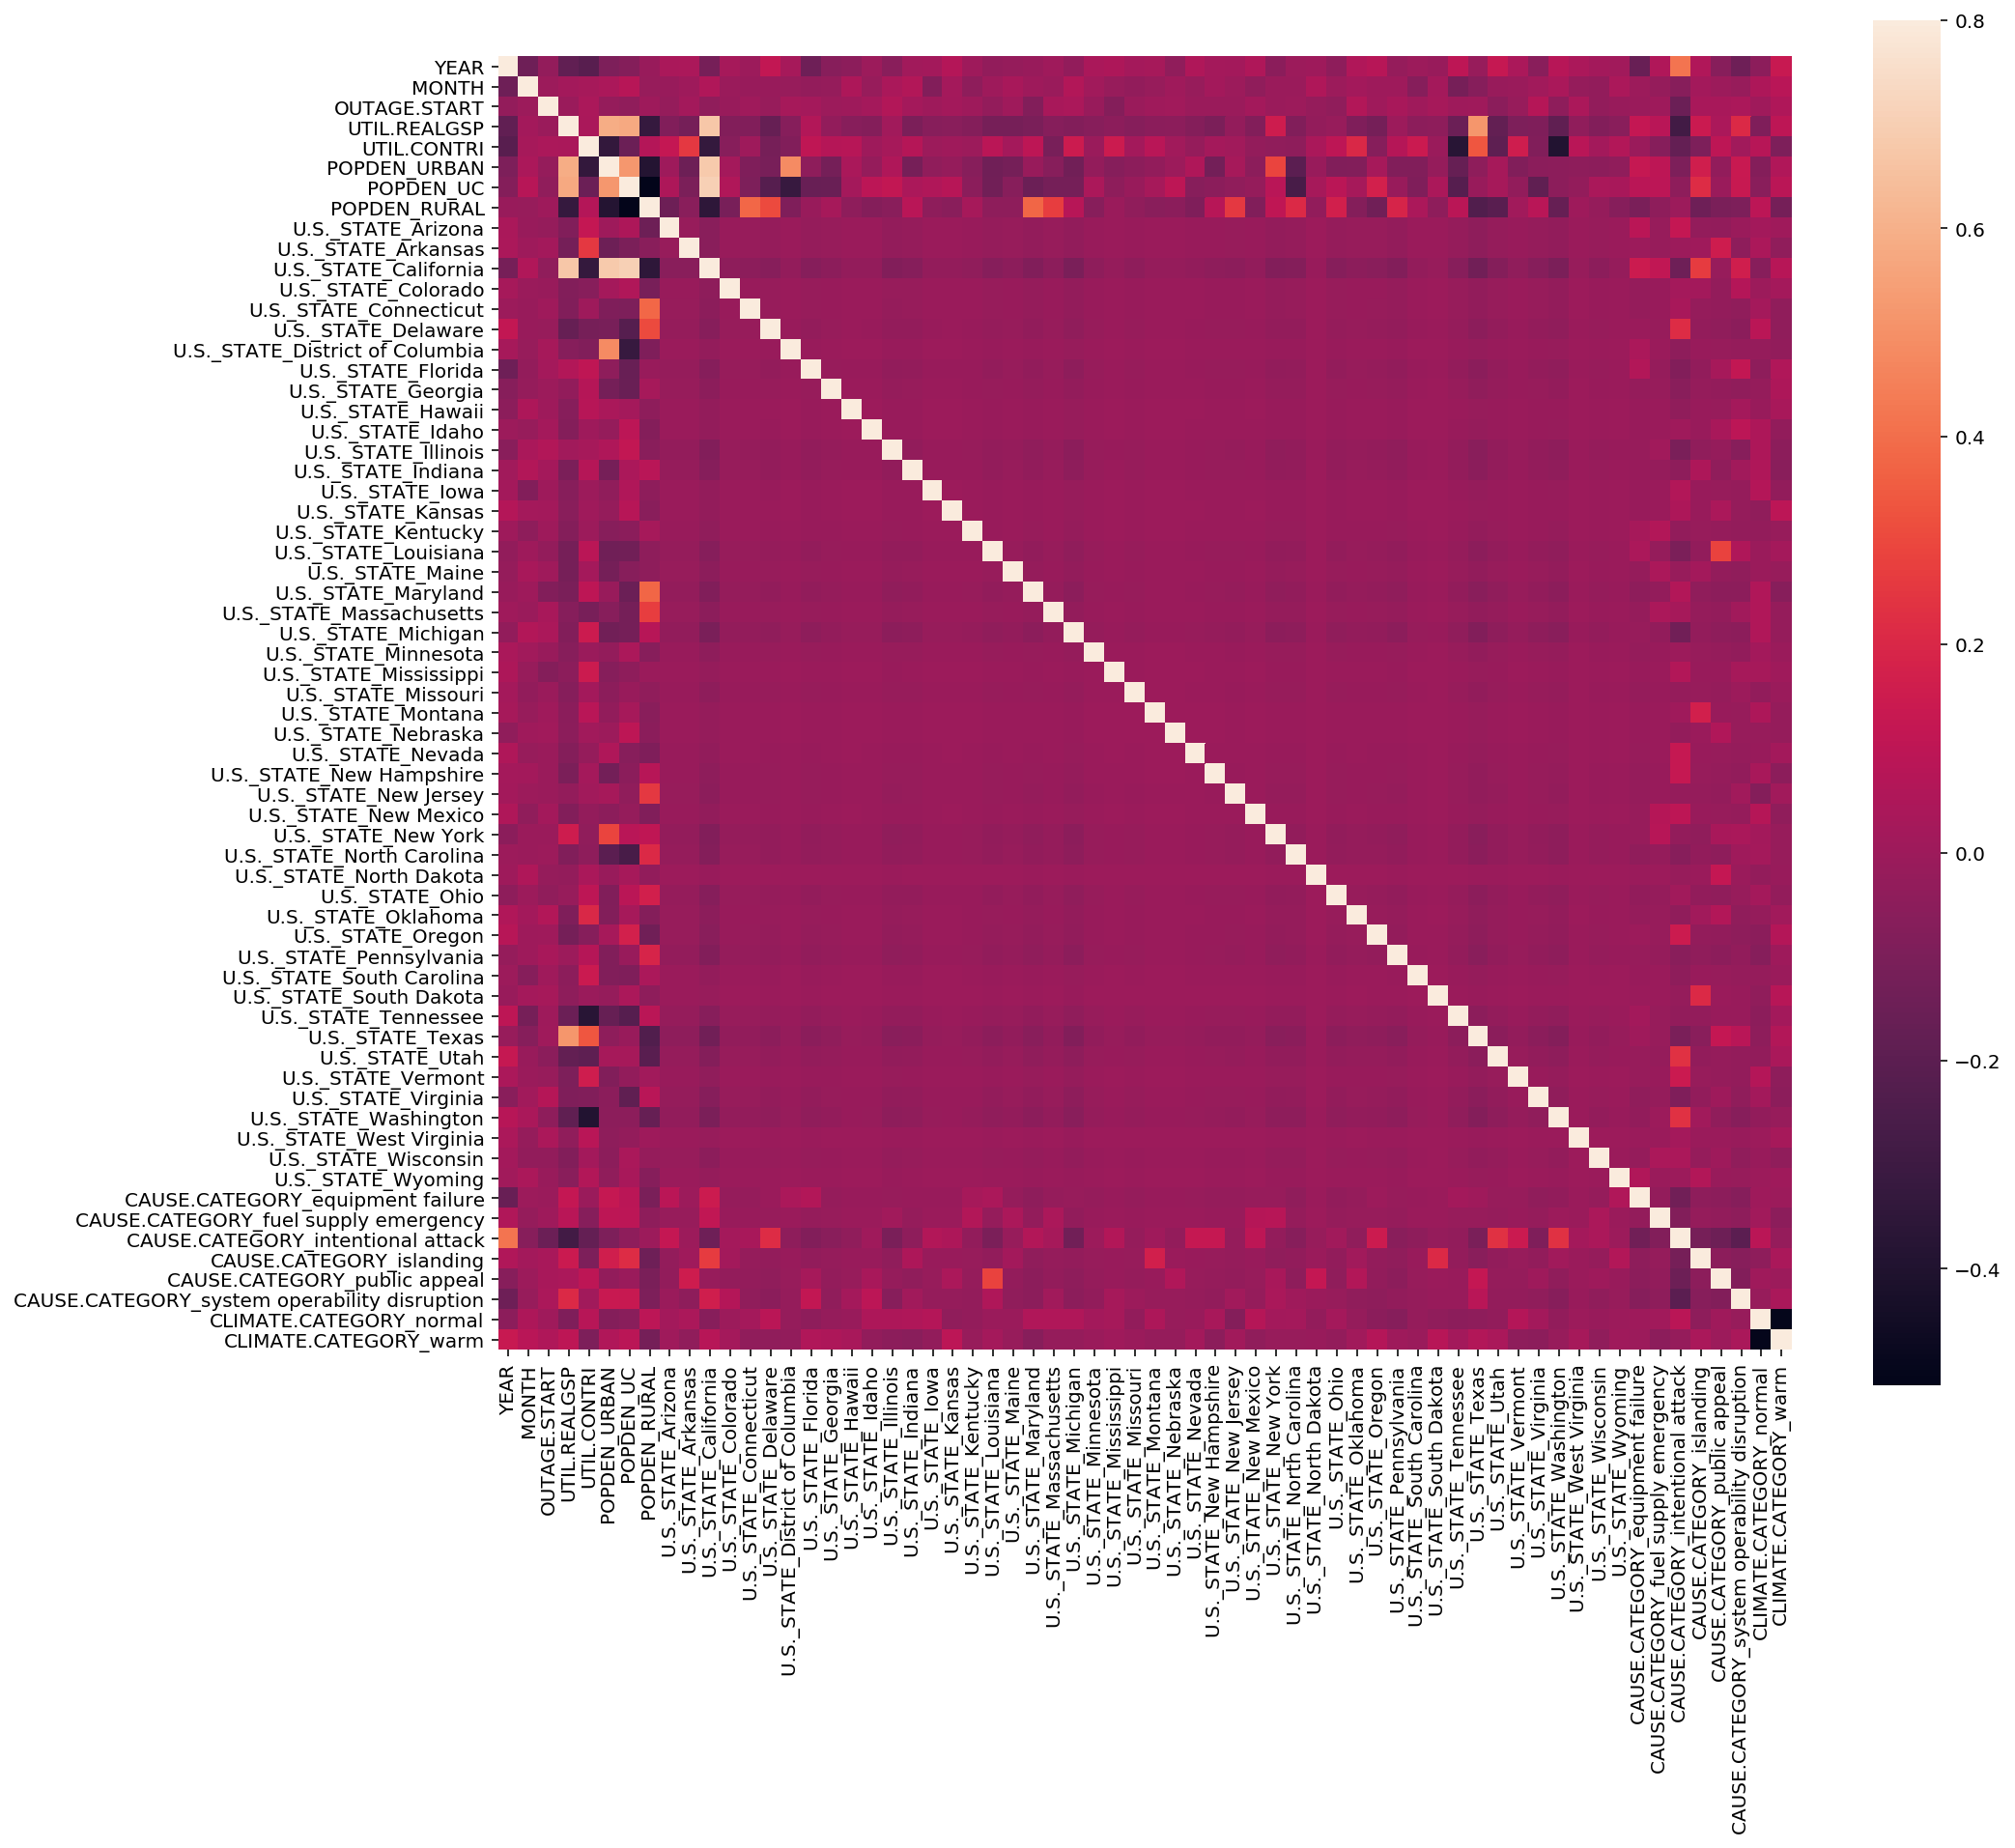

In [3]:
X = outages.copy()
X = X[['YEAR', 'MONTH', 'U.S._STATE', 'OUTAGE.START', 'CAUSE.CATEGORY', 'UTIL.REALGSP', 'UTIL.CONTRI', 'CLIMATE.CATEGORY', 'POPDEN_URBAN', 'POPDEN_UC', 'POPDEN_RURAL']]

X['UTIL.REALGSP'] = X['UTIL.REALGSP'].astype(float)
X['UTIL.CONTRI'] = X['UTIL.CONTRI'].astype(float)
X['YEAR'] = X['YEAR'].astype(int)
X['POPDEN_URBAN'] = X['POPDEN_URBAN'].astype(float)
X['POPDEN_UC'] = X['POPDEN_UC'].astype(float)
X['POPDEN_RURAL'] = X['POPDEN_RURAL'].astype(float)

y = outages['OUTAGE.DURATION']

num_nulls = X['MONTH'].isnull().sum()
samples = X['MONTH'].dropna().sample(num_nulls, replace=False)
samples.index = X.loc[X['MONTH'].isnull()].index
X = X.fillna({'MONTH': samples.to_dict()})

X['OUTAGE.START'] = X['OUTAGE.START'].apply(lambda x: x.hour)
num_nulls = X['OUTAGE.START'].isnull().sum()
samples = X['OUTAGE.START'].dropna().sample(num_nulls, replace=False)
samples.index = X.loc[X['OUTAGE.START'].isnull()].index
X = X.fillna({'OUTAGE.START': samples.to_dict()})

X['POPDEN_UC'] = X['POPDEN_UC'].fillna(0)
X['POPDEN_RURAL'] = X['POPDEN_RURAL'].fillna(0)


display(X)
display(y)

corrmat = pd.get_dummies(X).drop(columns=['U.S._STATE_Alabama', 'CAUSE.CATEGORY_severe weather', 'CLIMATE.CATEGORY_cold']).corr()
f, ax = plt.subplots(figsize=(15,13))
sns.heatmap(corrmat, vmax=0.8, square=True)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import sklearn.preprocessing as pp

### Baseline Model

In [7]:
temp_x = pd.get_dummies(X).drop(columns=['U.S._STATE_Alabama', 'CAUSE.CATEGORY_severe weather', 'CLIMATE.CATEGORY_cold'])
X_tr, X_ts, y_tr, y_ts = train_test_split(temp_x, y)


parameters = {'n_jobs': [1,2,3,5,7,10,15,20]}

clf = GridSearchCV(LinearRegression(), parameters, cv=5)
clf.fit(X_tr, y_tr)

clf.best_params_

{'n_jobs': 1}

In [160]:
def baseline_model():
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    oe = pp.OrdinalEncoder()
    ohe = pp.OneHotEncoder(handle_unknown='ignore')

    preproc_base = ColumnTransformer(transformers=[('onehotencoding', ohe, ['U.S._STATE', 'CAUSE.CATEGORY', 'CLIMATE.CATEGORY']),
                                                   ('ordinalencoding', oe, ['YEAR', 'OUTAGE.START', 'MONTH'])])

    pl_base = Pipeline(steps=[('preprocessor', preproc_base), ('regressor', LinearRegression(n_jobs=1))])
    pl_base.fit(X_train, y_train)

    return np.sqrt(np.sum((pl_base.predict(X_test) - y_test)**2)/len(X_test))

count     200.000000
mean     1184.048604
std        49.761141
min      1027.120084
25%      1152.457144
50%      1185.721887
75%      1211.969250
max      1320.055538
dtype: float64

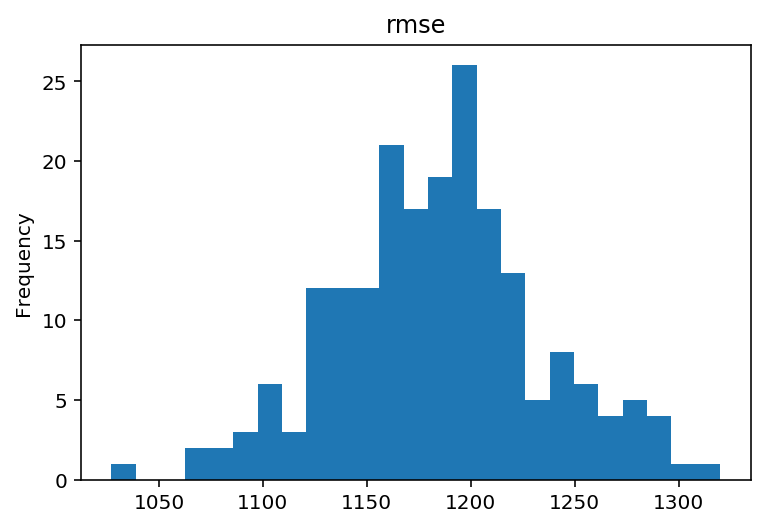

In [161]:
rmse = []
for i in range(200):
    rmse.append(baseline_model())

display(pd.Series(rmse).plot(kind='hist', title='rmse', bins=25))
display(pd.Series(rmse).describe())

### Final Model

In [141]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y)


parameters = {'preprocessor__categorical__pca__n_components': [None, 0.90, 0.95, 0.99]}

clf = GridSearchCV(final_model(), parameters, cv=5)
clf.fit(X_tr, y_tr)

clf.best_params_

{'preprocessor__categorical__pca__n_components': 0.9}

In [162]:
def final_model():
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    oe = pp.OrdinalEncoder()
    ohe = pp.OneHotEncoder(handle_unknown='ignore', sparse=False)
    normalize = pp.StandardScaler()
    
    pca, cat_cols = PCA(svd_solver='full', n_components=0.90), ['U.S._STATE', 'CAUSE.CATEGORY', 'CLIMATE.CATEGORY']
    cats = Pipeline(steps=[('ohe', ohe), ('pca', pca)])
    
    preproc_final = ColumnTransformer(transformers=[('categorical', cats, cat_cols),
                                                    ('ordinalencoding', oe, ['OUTAGE.START']),
                                                    ('zscore', normalize, ['UTIL.REALGSP', 'UTIL.CONTRI'])],
                                     remainder='passthrough')


    pl_final = Pipeline(steps=[('preprocessor', preproc_final), ('regressor', LinearRegression(n_jobs=1))])
    pl_final.fit(X_train, y_train)

    return np.sqrt(np.sum((pl_final.predict(X_test) - y_test)**2)/len(X_test))

count     200.000000
mean     1177.130570
std        49.334235
min      1054.335087
25%      1140.893297
50%      1172.873694
75%      1211.937685
max      1337.725541
dtype: float64

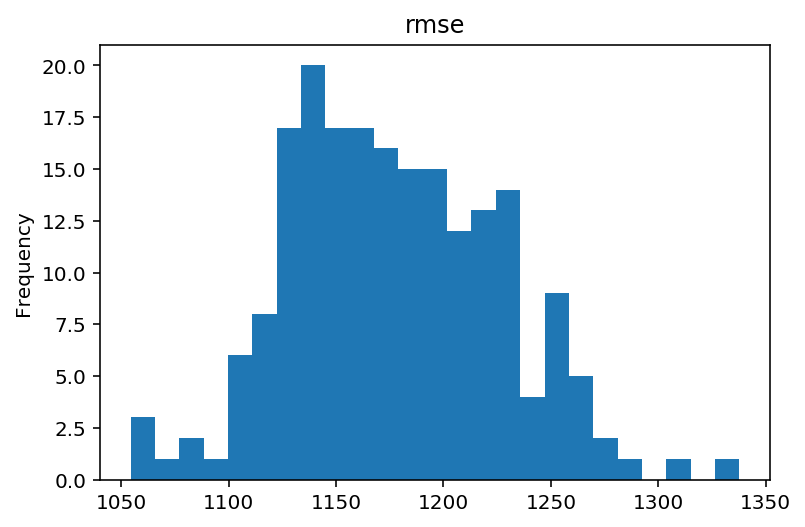

In [163]:
rmse = []
for i in range(200):
    rmse.append(final_model())

display(pd.Series(rmse).plot(kind='hist', title='rmse', bins=25))
display(pd.Series(rmse).describe())

### Fairness Evaluation

In [144]:
X['first_half'] = X['MONTH'] <= 6

In [172]:
def fairness_evaluation(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    oe = pp.OrdinalEncoder()
    ohe = pp.OneHotEncoder(handle_unknown='ignore', sparse=False)
    normalize = pp.StandardScaler()
    
    pca, cat_cols = PCA(svd_solver='full', n_components=0.90), ['U.S._STATE', 'CAUSE.CATEGORY', 'CLIMATE.CATEGORY']
    cats = Pipeline(steps=[('ohe', ohe), ('pca', pca)])
    
    preproc_final = ColumnTransformer(transformers=[('categorical', cats, cat_cols),
                                                    ('ordinalencoding', oe, ['OUTAGE.START']),
                                                    ('zscore', normalize, ['UTIL.REALGSP', 'UTIL.CONTRI'])],
                                     remainder='passthrough')


    pl_final = Pipeline(steps=[('preprocessor', preproc_final), ('regressor', LinearRegression(n_jobs=1))])
    pl_final.fit(X_train, y_train)

    return np.sqrt(np.sum((pl_final.predict(X_test) - y_test)**2)/len(X_test))

In [175]:
true_rmse_obs = []
false_rmse_obs = []

for i in range(250):
    first_half = X[X['first_half']==True].iloc[:, :-1]
    first_half_y = outages.loc[first_half.index, 'OUTAGE.DURATION']

    not_first_half = X[X['first_half']==False].iloc[:, :-1]
    not_first_half_y = outages.loc[not_first_half.index, 'OUTAGE.DURATION']

    true_rmse_obs.append(fairness_evaluation(first_half, first_half_y))
    false_rmse_obs.append(fairness_evaluation(not_first_half, not_first_half_y))

display('observed statistics')

true_rmse_obs = np.mean(true_rmse_obs)
false_rmse_obs = np.mean(false_rmse_obs)

print('true rmse: ' + str(true_rmse_obs))
print('false rmse: ' + str(false_rmse_obs))

'observed statistics'

true rmse: 1192.168080644744
false rmse: 1193.402487280718


In [176]:
N = 500
true_rmse = []
false_rmse = []

x = X.copy()

for i in range(N):
    x['shuffled'] = x['first_half'].sample(replace=False, frac=1).reset_index(drop=True)
    
    first_half = x[x['shuffled']==True].iloc[:, :-1]
    first_half_y = outages.loc[first_half.index, 'OUTAGE.DURATION']

    not_first_half = x[x['shuffled']==False].iloc[:, :-1]
    not_first_half_y = outages.loc[not_first_half.index, 'OUTAGE.DURATION']
    
    true_rmse.append(fairness_evaluation(first_half, first_half_y))
    false_rmse.append(fairness_evaluation(not_first_half, not_first_half_y))

pval: 0.526000


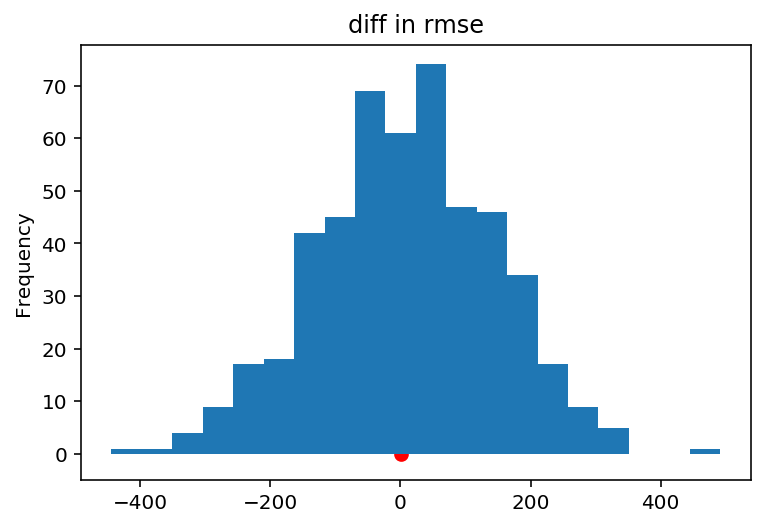

In [177]:
(pd.Series(false_rmse) - pd.Series(true_rmse)).plot(kind='hist', bins=20, title='diff in rmse')
plt.scatter([false_rmse_obs - true_rmse_obs], 0, c='red', s=40)
pval = (pd.Series(false_rmse) - pd.Series(true_rmse) > false_rmse_obs - true_rmse_obs).mean()
print('pval: %f' % pval)